In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import cylinder_dataset_generator as cyl
from importlib import reload

reload(mcu)
reload(cyl)

<module 'cylinder_dataset_generator' from 'C:\\Users\\einkina\\Documents\\School\\Manifold Learning\\manifold-learning\\cylinder_dataset_generator.py'>

In [3]:
control_vars = cyl.get_control_vars()
response_matrix = cyl.generate_array_of_cylinders(control_vars, noise_level=0, num=200)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)

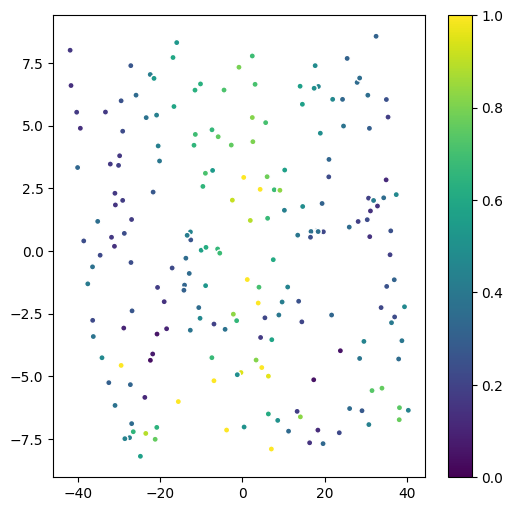

0.38407450473450366


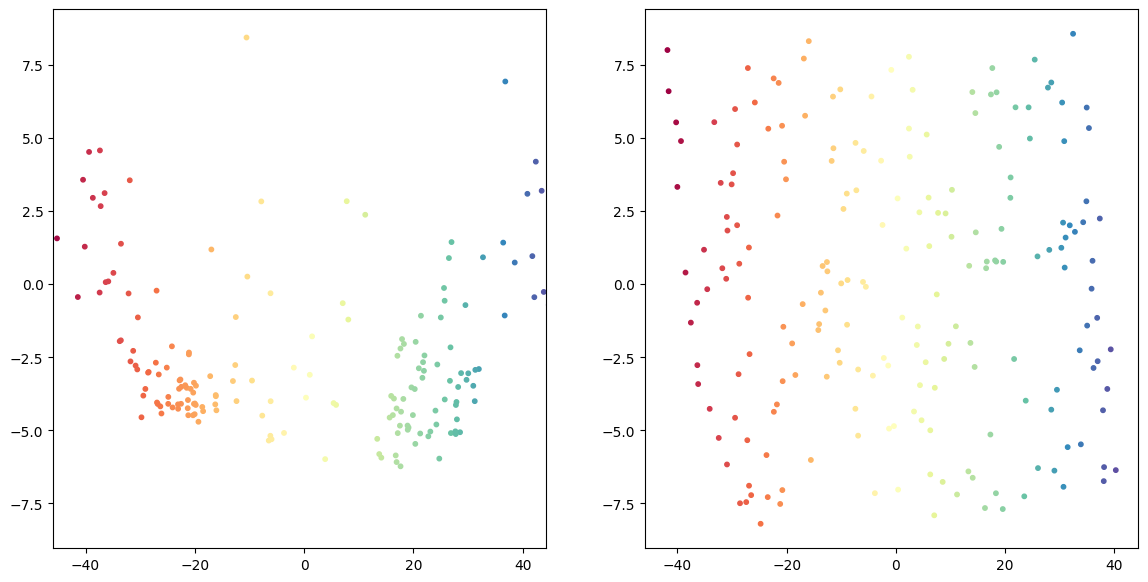

In [4]:
reload(mcu)
reload(cyl)
ld_embedding = mcu.reduce_dimensions(q)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

rre = mcu.compute_rre(ld_embedding, reconstructed_y)
mcu.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))
mcu.plot_two_embeddings(ld_embedding, reconstructed_y)

In [5]:
reload(mcu)
reload(cyl)
test_control_vars = cyl.get_control_vars(100)
test_rolls = cyl.generate_array_of_cylinders(test_control_vars, 0, 100)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [4.5398388  6.11447288], x_err = 1.7981381365376643e-14
x_real = [0.6980736263648613, 4.173523599385598]
-----------
x_opt  = [3.78672902 3.89809774], x_err = 8.828554497071297e-15
x_real = [7.452277632093213, 8.061573476022117]
-----------
x_opt  = [1.27525759 6.35659275], x_err = 3.752567174601736e-14
x_real = [0.7221027622197806, 4.669785398361599]
-----------
x_opt  = [2.97735421 3.00388122], x_err = 4.115574027585452e-14
x_real = [6.250347247784579, 8.275350972291829]
-----------
x_opt  = [6.2403558  7.78867935], x_err = 3.531018295562515e-14
x_real = [9.075296546929955, 2.714726063170687]
-----------
x_opt  = [2.26724405 5.0401103 ], x_err = 1.158589273977399e-14
x_real = [2.2254309881398946, 2.552925514362252]
-----------
x_opt  = [4.92085849 1.85739927], x_err = 3.5075740405872934e-14
x_real = [5.52083130340277, 2.4926923354408617]
-----------
x_opt  = [3.91059503 5.10759677], x_err = 3.809088762584981e-14
x_real = [2.584177512927134, 2.4388991403547755]
--

[4.30423556 5.54714133 1.77518993 6.20490748 5.81221911 2.48753623
 0.87382187 2.98015611 5.38523108 5.35690878 7.59164958 4.16262014
 3.19189701 4.11771997 2.66373592 3.57059547 4.47765854 4.53332412
 1.26220142 3.49753381 5.63059227 1.31518086 3.37892331 4.02601448
 6.83372604 1.22201064 4.4770439  6.05152205 3.01474779 1.86109944
 2.84728287 1.54337517 4.5472734  3.1539371  0.98539811 2.23372127
 4.38812921 5.90899532 1.58563365 8.71836343 1.04501646 4.1511265
 5.83151551 2.76875207 8.47212393 8.05708467 3.01439853 4.11028524
 4.38091334 4.22655996 1.71961355 4.63320128 1.51557558 4.35740259
 1.5242679  2.63739363 2.56451056 3.53090131 5.83226689 2.90177412
 9.28027982 4.08881582 3.73269816 3.08307502 3.71883433 5.289427
 2.50175074 3.88792198 4.83541274 3.12312583 3.27372274 4.6212792
 2.47714036 5.39703193 8.68187371 6.21889107 6.50666576 6.01734024
 3.21008183 5.30999393 1.97288896 4.81118567 0.53822589 0.725954
 3.1538563  3.66094155 5.51138935 1.62385991 2.1948048  3.57108578
 

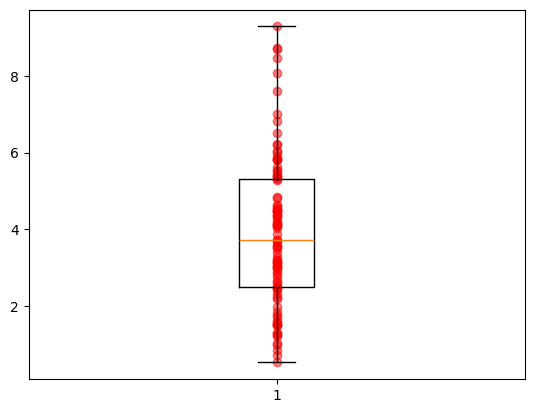

In [6]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")